# Import necessary packages

In [1]:
# Written by Mohd Ibrahim
# Institute of Physics, University of Augsburg, Germany
# email: ibrahim.mohd@physik.uni-augsburg.de

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

from matplotlib import gridspec
from scipy.interpolate import interp1d
from tqdm import tqdm 


plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
plt.rc('axes', labelsize=16)

%matplotlib inline

In [2]:
# import Refnx packages
from refnx.reflect import SLD, Slab, ReflectModel
from refnx.reflect import reflectivity, Structure
from refnx.analysis import CurveFitter, Objective, Parameter, GlobalObjective
from refnx.dataset import Data1D

# Grazing Incidence X-ray Off-specular Scattering  (GIXOS)

The GIXOS intensity from simulations (and experiments) is given by, <br>
\begin{aligned}
I_{sim} (q_z) = \frac{ V(q_z) R_q(q_z)} {R_F(q_z)}
\end{aligned}

Where, <br>
1. V($q_z$), is the Vineyard function, it is defined as follows

\begin{aligned}
V(Q) = 
\begin {cases}
0 & \text {,for Q<0} \\
|2Q|^2 & \text {,for 0<Q<1} \\
\left|\frac{2Q}{Q+ \sqrt{Q^2-1}}\right|^2 & \text {,for Q>1}
\end{cases}
\end{aligned}


Where, $Q = \frac{q_z}{q_v}$, $q_v = \sqrt{16 \pi\rho_b}$ 

$\rho_b$ is the electron density of bulk water times the classical electron radius ($2.8179403227\times 10^{-15}$ m)

<br>
<br>

2. $R_q(q_z),$ is the standard specular reflectivity intensity and $R_F(q_z)$ is the Fresnel reflectivity from an infinitely sharp (roughness=0) Air-Water interface 


<br>
<br>

3. Once we obtain $I_{sim} (q_z)$ from simulations, to compare with experiments we find an offset and scale factor that minimizes $\chi^2$ between experiments and simulations.The final scattered intensity is given by,

\begin{aligned} &
I (q_z) = \text{ScaleFactor} \times I_{sim} (q_z)+ \text{Offset} 
\end{aligned}


## Useful functions

In [3]:
def interpolate(sld,points):
    
    '''
    interpolates the input sld into specified number of points
    '''
    
    size = np.shape(sld)
    sldinterpolated = np.zeros((points,size[1]))
    x = sld[:,0]
    sldinterpolated[:,0] = np.linspace(min(x),max(x),points)
    for j in range(1,size[1]):
        
        y=sld[:,j]
        f = interp1d(x, y, kind='linear')
        sldinterpolated[:,j]= f(sldinterpolated[:,0])
        
    return sldinterpolated



def Fresnal_coefficient (bulk_sld, air_sld=0, thickness=5.0, roughness=0.0, return_sld = False):
    
    '''
    This functions calculates the Fresnel reflectivity from Air-water interface. The interface is assumed to be
    infinitely sharp i.e roughness=0
    
    args:
        bulk_sld: Bulk sld of water typically its  (0.333 e/A^3)
        air_sld: Default = 0, sld of air
        
        thickness:  of the interfaces, this thicness does not matter since one is the incoming medium and the other
        is the outgoing medium
        
        roughness: of air-water interface, for the above GIXOS equation its zero i.e infinitely sharp
        
        return_sld: If set True return the total SLD of the interfaces, instead of returning the Fresnal reflectivity
        intesity
        
    returns:
        if "return_sld=Flase": returns Fresnel reflectivity intensity
        
        otherwise: returns the full SLD of the interface (Air-Water)
    '''
    
    
    Vaccum         =  Slab(thickness, air_sld, roughness, name='air')
    
    Aqueous_medium =  Slab(thickness, bulk_sld, roughness,name='water')
    
    Substrate_structure = Vaccum | Aqueous_medium
    
    R_calculated  = ReflectModel(Substrate_structure,dq=5,bkg=0)
    
    if return_sld : return Substrate_structure
    
    return R_calculated



def vineyard (q, rho_bulk):
    
    '''
    Calculates the vineyard function described in the Markdown
    All units in Angstroms
    
    args:
        q: q_z range, should be identical as used for Rq (q_z) and R_F (qz)
        
        rho_bulk: Bulk sld (electron density) of water typically its  (0.333 e/A^3)
        
    return:
         Vineyard: v(q_z) function displayed in the Markdown
    '''
    
    Vineyard =  []
    
    classical_electron_radius = 2.8179403227e-15 /1e-10 # Angstorm 
    
    rho_b      =   rho_bulk * classical_electron_radius
    
    qv         =   np.sqrt (16*np.pi*rho_b)
    
    Q          =   q/qv
        
    
    for q_i in Q:
        
        if q_i <= 0: Vineyard.append (0)
        
        if q_i >0 and q_i <=1:  Vineyard.append( (2*q_i)**2)  
        
        if q_i > 1: 
                   
            func =  (2*q_i / (q_i + np.sqrt (q_i**2-1)) )**2
            
            Vineyard.append(func)  
            
    
    #threshold_index = np.where (Q <= 0)[0][-1]
    
    return np.array (Vineyard)





def Reflectivity_from_SLD (sld, q = np.linspace(0.001,0.8,500), return_sld=False,layer_thickness =1.0, roughness=0):
    
    '''
       Calculates specular reflectivity by slicing the input sld profile. Uses the Abele's matrix formalism
       
       args:
           sld: the sld profile, a 2D array with first coloumn z-distance and 2nd coloum as the sld
           Note that the calculation assumes the x-ray is incident upon the left side of the sld
           
           q: the range of momenta transfer in Angstroms^-1. Default is unit 0.8. To compare with experiments the q values from
           experiments must be provided
           
           return_sld: if set True, returns the sliced up sld profile. If False returns the reflectivity profile.
           
           layer_thickness: Thickness of sld slices. Default is 1.0 angstroms
           roughness: roughness of each sld slices. Default is zeros. For 1.0 Angstrom thick layers, non-zeros roughness does not make sense
           
           
        returns:
            Reflectivity: if return_sld = False, Default behaviour
            Sliced SLD:  if return_sld = True.
    
    '''
    sld  = interpolate (sld, 800)
    # Since up sld
    Ref, Sld2 = Reflectivity_input (sld, layer_thickness=layer_thickness, roughness= roughness)
    
     

    Str=[]

    for i in range(0,len(Ref)):
        c=Slab(Ref[i][0], Ref[i][1], Ref[i][3])
        Str.append(c)

    structure = Structure(Str)

    R_calculated = ReflectModel(structure, dq=0, bkg=0)


    if return_sld:      return structure

    else: return R_calculated
    

    

def Reflectivity_input (sld, layer_thickness=1, roughness=0):
    
    '''
       Takes the SLD profile and slices it up in constant sld layers
       args:
           sld: a 2D sld array to be sliced. First coloumn is z-distance and 2nd is electron density or sld
           
           layer_thickness: Thickness of sld slices. Default is 1.0 angstroms
           
          roughness: roughness of each sld slices. Default is zero
          
        returns:
              
           Ref: Refnx style "Slab" data structure containing paramters for each slice. The info are roughness, thickness, sld,
           SLD2: Sliced up SLD profile, just for verification if needed, to make sure slicing up is correct
    '''
    
    
    dz = np.abs(np.diff(sld[:,0])[0])

    number_of_slabs = round((max(sld[:,0]) - min(sld[:,0])) / layer_thickness ) +1
    number_of_slabs = int(number_of_slabs)
    ave= int(round(len(sld) / number_of_slabs))# sld_points_in_a_slab 
    
    #################
    s = len(sld)-number_of_slabs*ave
    d = int(np.floor((s/ave)))
    SLD2=np.zeros((len(sld)-ave,2))
    SLD2[:,0] = sld[0:len(sld)-ave,0]
    ###########---------------
    j = 0
    SLD_layer=[]
    
    for i in range(0,number_of_slabs+d):
        sld_slab = sum(sld[j:j+ave,1])/ave
        SLD2[j:j+ave,1]=sld_slab
        j=j+ave
        SLD_layer.append(sld_slab)
        
    
    Ref = np.zeros((len(SLD_layer),4))
    
    for i in range(0,len(Ref)):
        Ref[i][0] = layer_thickness 
        Ref[i][1] = SLD_layer[i]
        Ref[i][2] = 0  #sld_slab[i]
        Ref[i][3] = roughness  #2.0*random.random()-0.5#sld_slab[i]]
        
    return Ref, SLD2



def search_for_scale_and_offset (kwargs, experimental_Iq, simulation_Iq, N_grid_points = 500, return_chi=False):
    
    end = 1
    
    experimental_Iq  = experimental_Iq [:-end]
    
    simulation_Iq  = simulation_Iq [:-end]
    
    n_data_points = len(experimental_Iq)
    
    Offset = np.linspace (kwargs['min_offset'], kwargs['max_offset'], N_grid_points)
    
    Scale  = np.linspace (kwargs ['min_scale'], kwargs ['max_scale'], N_grid_points)
    
    
    
    Offset          = np.linspace (kwargs['min_offset'], kwargs['max_offset'], N_grid_points)

    Scale           = np.linspace (kwargs ['min_scale'], kwargs ['max_scale'], N_grid_points)
    

    parameter_space = [(scale, offset) for scale in Scale for offset in Offset]
    
    Chi_sq  = []
    
    
    for scale, offset in tqdm (parameter_space):
        
        New_Iq        = scale * simulation_Iq + offset 
        
        
        # Chi square
        
        chi_sq = sum ((New_Iq - experimental_Iq ) **2) / n_data_points
        
        Chi_sq.append (chi_sq)
        
       
    arg_min = np.argmin (Chi_sq)
    
    
    if return_chi: return parameter_space[arg_min][0], parameter_space[arg_min][1], min (Chi_sq)
    
    return parameter_space[arg_min][0], parameter_space[arg_min][1]
        

# Example

## Calculate GIXOS from simulations SLD

Text(0, 0.5, ' Intensity [ A.U ]')

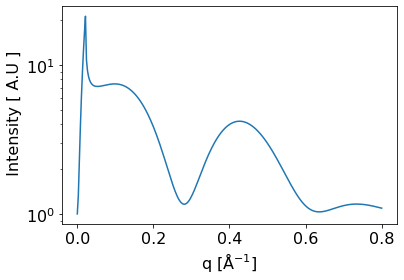

In [13]:
# Load SLD profile

Dens_sim = np.genfromtxt ("./example-data/dens_46.dat")

## Convert to Angstrom cube
Dens_sim [:,0] *= 10
Dens_sim [:,1] /= 1e3

# Obtain Rq
Rq         =   Reflectivity_from_SLD (Dens_sim)

# get bulk density
bulk_sld   =   np.average (Dens_sim [-15:,1])

# obtain fresnel coefficient
Rf         =   Fresnal_coefficient(bulk_sld, roughness=0, return_sld=False)

# q values 
q = np.linspace (1e-4, 0.8, 300)

# Obtain the Vineyard function
Vineyard = vineyard (q , rho_bulk=bulk_sld)


# Iq from simulations 

I_sim =     Vineyard*Rq(q) / Rf(q)

# I multiply by a scaling factor and add an offset just to make it appear like experiemnts.
scale, offset = 5,  1

plt.semilogy (q, scale*I_sim + offset)

plt.xlabel ("q [$\mathrm{\AA^{-1}}$]")

plt.ylabel (" Intensity [ A.U ]")

## Direct comparison of experiment and simulation

100%|██████████████████████████████████████████████| 1000000/1000000 [00:41<00:00, 24149.63it/s]


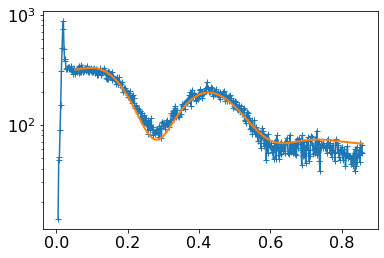

In [36]:
Iq_exp         =   np.genfromtxt ("./example-data/gixos_exp.dat", skip_header=10)
q1             =   Iq_exp[:-24,4]
I_exp1         =   Iq_exp[:-24,2]


###
q_exp_fit    = Iq_exp [:-50, 4] # skip some experimental point at the beginning
I_exp_fit    = Iq_exp [:-50,2]

#############################
Vineyard = vineyard (q_exp_fit , rho_bulk=bulk_sld)
I_sim =     Vineyard*Rq(q_exp_fit) / Rf(q_exp_fit)

# Obtain optimum offset and scale factor
kwargs = dict (min_offset = -10, max_offset=200, min_scale = 0.0, max_scale = 500) 

scale, offset, min_chi = search_for_scale_and_offset (experimental_Iq = I_exp_fit, simulation_Iq=I_sim, 
                                             kwargs=kwargs, N_grid_points=1000,return_chi=True)

plt.semilogy (q1, I_exp1, marker='+')
plt.semilogy (q_exp_fit, scale*I_sim+offset, lw=2)

## Plot stratified electron density and the final GIXOS profiles

Text(0.5, 0, 'z $[\\mathrm{\\AA}]$')

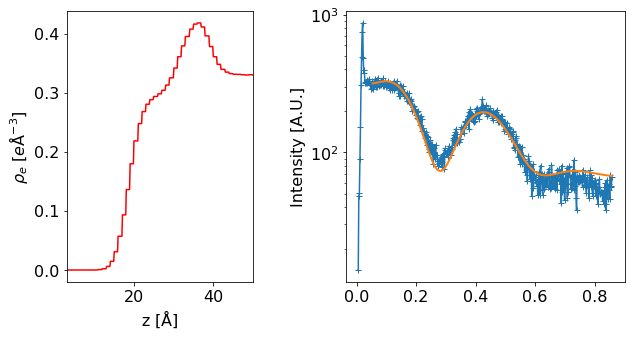

In [66]:
fig    =     plt.figure(figsize=(10,5))
gs     =     fig.add_gridspec(nrows=1, ncols=2,width_ratios=[1,1.5], wspace=0.4)


Rq         =   Reflectivity_from_SLD (Dens_sim, return_sld=True)

ax1    =     fig.add_subplot(gs[0, 0])
ax1.plot (*Rq.sld_profile (), color='r')
ax1.set_xlim (3,50)
ax1.set_ylabel ("$\\rho_e$ $[e\mathrm{\AA}^{-3}]$")
ax1.set_xlabel ("z $[\mathrm{\AA}]$")
ax2    =     fig.add_subplot(gs[0, 1])


ax2.semilogy (q1, I_exp1, marker='+')
ax2.semilogy (q_exp_fit, scale*I_sim+offset, lw=2)

ax2.set_ylabel ("Intensity [A.U.]")
ax2.set_xlabel ("q $[\mathrm{\AA}^{-01}]$")

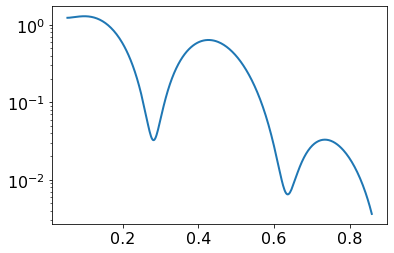

In [34]:
plt.semilogy (q_exp_fit, I_sim, lw=2)

In [23]:
len (q_exp_fit)

437

In [24]:
len (I_sim)

437